<a href="https://colab.research.google.com/github/gwarishubham01/Elevate_labs_Final_project/blob/main/CLV_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OBJECTIVE:** Predict the lifetime value(LTV) of customers based on their purchase behavior to aid in targeted market.

In [61]:
#Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

from datetime import datetime, timedelta,date
from __future__ import division

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

Load the Dataset.

In [62]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cameronseamons/electronic-sales-sep2023-sep2024")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electronic-sales-sep2023-sep2024


In [63]:
df = (pd.read_csv("/kaggle/input/electronic-sales-sep2023-sep2024/Electronic_sales_Sep2023-Sep2024.csv"))
df.head()

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
2,1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,NaN,0.00
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,2024-05-21,Express,Accessory,35.56


In [64]:
#Feature Selection
features = ["Customer ID","SKU","Product Type","Quantity","Purchase Date","Unit Price","Order Status","Total Price"]
df_clv = df[features]
df_clv.head()

,Customer ID,SKU,Product Type,Quantity,Purchase Date,Unit Price,Order Status,Total Price
0,1000,SKU1004,Smartphone,7,2024-03-20,791.19,Cancelled,5538.33
1,1000,SKU1002,Tablet,3,2024-04-20,247.03,Completed,741.09
2,1002,SKU1005,Laptop,4,2023-10-17,463.96,Completed,1855.84
3,1002,SKU1004,Smartphone,4,2024-08-09,791.19,Completed,3164.76
4,1003,SKU1001,Smartphone,2,2024-05-21,20.75,Completed,41.50


In [65]:
le = LabelEncoder()
df_clv['Order Status'] = le.fit_transform(df_clv['Order Status'])
df_clv.head()

,Customer ID,SKU,Product Type,Quantity,Purchase Date,Unit Price,Order Status,Total Price
0,1000,SKU1004,Smartphone,7,2024-03-20,791.19,0,5538.33
1,1000,SKU1002,Tablet,3,2024-04-20,247.03,1,741.09
2,1002,SKU1005,Laptop,4,2023-10-17,463.96,1,1855.84
3,1002,SKU1004,Smartphone,4,2024-08-09,791.19,1,3164.76
4,1003,SKU1001,Smartphone,2,2024-05-21,20.75,1,41.50


In [66]:
df_clv = df_clv[df_clv['Order Status'] == 1]

df_clv = df_clv.drop('Order Status', axis=1)
df_clv.head()

,Customer ID,SKU,Product Type,Quantity,Purchase Date,Unit Price,Total Price
1,1000,SKU1002,Tablet,3,2024-04-20,247.03,741.09
2,1002,SKU1005,Laptop,4,2023-10-17,463.96,1855.84
3,1002,SKU1004,Smartphone,4,2024-08-09,791.19,3164.76
4,1003,SKU1001,Smartphone,2,2024-05-21,20.75,41.50
5,1004,SKU1001,Smartphone,4,2024-05-26,20.75,83.00


In [67]:
df_clv.describe()

,Customer ID,Quantity,Unit Price,Total Price
count,13432.000000,13432.000000,13432.000000,13432.000000
mean,10489.175923,5.483175,577.884580,3173.735525
std,5645.839418,2.865306,312.827677,2541.476958
min,1000.000000,1.000000,20.750000,20.750000
25%,5452.750000,3.000000,361.180000,1083.540000
50%,11025.500000,5.000000,463.960000,2534.490000
75%,15507.500000,8.000000,791.190000,4639.600000
max,19998.000000,10.000000,1139.680000,11396.800000


In [68]:
pd.DataFrame(zip(df_clv.isnull().sum(), df_clv.isnull().sum()/len(df_clv)), columns=['Count', 'Proportion'], index=df_clv.columns)

,Count,Proportion
Customer ID,0,0.0
SKU,0,0.0
Product Type,0,0.0
Quantity,0,0.0
Purchase Date,0,0.0
Unit Price,0,0.0
Total Price,0,0.0


In [69]:
#Details of the dataset
max_date = df_clv['Purchase Date'].max()
min_date = df_clv['Purchase Date'].min()
unique_cus = df_clv['Customer ID'].nunique()
unique_sku = df_clv['SKU'].nunique()
tot_sales = df_clv["Total Price"].sum()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)
print("Unique Customers:", unique_cus)
print("Unique SKU:", unique_sku)
print("Total Sales:", tot_sales)

Maximum Date: 2024-09-23
Minimum Date: 2023-09-24
Unique Customers: 9466
Unique SKU: 10
Total Sales: 42629615.57


Customer Life Time Value using Aggregate Model

In [70]:
df_clv['Purchase Date'] = pd.to_datetime(df_clv['Purchase Date'])
df_clv['Invoice_Year_Month'] = df_clv['Purchase Date'].map(lambda date: 100*date.year + date.month)
new_df_clv  = df_clv.groupby('Customer ID').agg({'Purchase Date': lambda x: (x.max() - x.min()).days,
                                       'SKU': lambda x: len(x),
                                       'Total Price': lambda x: x.sum()})
new_df_clv.columns = ['Age', 'Frequency', 'TotalSpent']
new_df_clv.head()

,Age,Frequency,TotalSpent
Customer ID,,,
1000,0,1,741.09
1002,297,2,5020.60
1003,0,1,41.50
1004,0,1,83.00
1005,146,2,11779.11


General formula for Calculating **Customer Lifetime Value** is:  

  *CLV = (( Average Sales X Purchase Frequency) X Churn ) X Profit Margin*

In [71]:
#Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(new_df_clv['TotalSpent']),2)
Purchase_frequency = round(np.mean(new_df_clv['Frequency']),2)
Churn = round(np.mean(new_df_clv['Age']),2)
Profit_margin = 0.2
print(f"Average Sales: ${Average_sales}")
print(f"Purchase Frequency: {Purchase_frequency}")
retention_rate = new_df_clv[new_df_clv['Frequency']>1].shape[0]/new_df_clv.shape[0]
churn = round(1 - retention_rate, 2)
print(f"Churn rate: {Churn}%")

Average Sales: $4503.45
Purchase Frequency: 1.42
Churn rate: 38.71%


In [72]:
#Calculating the CLV
CLV = (Average_sales * Purchase_frequency * Churn) * Profit_margin
print(f"The Customer Lifetime Value for each customer is: ${CLV}")

The Customer Lifetime Value for each customer is: $49509.308057999995


Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups and calculate the CLV for each group. This model overcomes the major drawback of the simple Aggregate model which assumes the entire customers as a single group. This is called the **Cohort model**.

In [73]:
customer_cohort = df_clv.groupby('Customer ID').agg({'Purchase Date': lambda x: x.min().month,
                                       'SKU': lambda x: len(x),
                                       'Total Price': lambda x: x.sum()})
customer_cohort.columns = ['Start_month','Frequency','Total_sales']
customer_cohort.head()

,Start_month,Frequency,Total_sales
Customer ID,,,
1000,4,1,741.09
1002,10,2,5020.60
1003,5,1,41.50
1004,5,1,83.00
1005,1,2,11779.11


In [74]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_clv = []

for i in range(len(months)):
    customer_month = customer_cohort[customer_cohort['Start_month'] == i+1]
    Average_sales = round(np.mean(customer_month['Total_sales']),2)
    Purchase_frequency = round(np.mean(customer_month['Frequency']),2)
    Churn = round(np.mean(customer_month['Start_month']),2)
    Profit_margin = 0.2
    CLV = (Average_sales * Purchase_frequency * Churn) * Profit_margin
    monthly_clv.append(CLV)

Clv_monthly = pd.DataFrame(zip(months,monthly_clv), columns=['Month','CLV'])
Clv_monthly

,Month,CLV
0,Jan,1794.78322
1,Feb,3215.32000
2,Mar,4172.97240
3,Apr,5533.04448
4,May,5558.02000
5,Jun,6596.61876
6,Jul,6707.59628
7,Aug,6130.40832
8,Sep,8102.36160
9,Oct,13986.00000


**Customer Lifetime Value Using Machine Learning Model**

In [77]:
df_clv.head()
df_clv.columns = ['Customer_ID','SKU','Product_Type','Quantity','Purchase_Date','Unit_Price','Total_Price','Invoice_Year_Month']
df_clv.head()

,Customer_ID,SKU,Product_Type,Quantity,Purchase_Date,Unit_Price,Total_Price,Invoice_Year_Month
1,1000,SKU1002,Tablet,3,2024-04-20,247.03,741.09,202404
2,1002,SKU1005,Laptop,4,2023-10-17,463.96,1855.84,202310
3,1002,SKU1004,Smartphone,4,2024-08-09,791.19,3164.76,202408
4,1003,SKU1001,Smartphone,2,2024-05-21,20.75,41.50,202405
5,1004,SKU1001,Smartphone,4,2024-05-26,20.75,83.00,202405


In [79]:
customer = pd.DataFrame(df_clv['Customer_ID'].unique())
customer.columns = ['Customer_ID']
customer.head()

,Customer_ID
0,1000
1,1002
2,1003
3,1004
4,1005


In [81]:
customer_max_purchase = df_clv.groupby('Customer_ID').Purchase_Date.max().reset_index()
customer_max_purchase.columns = ['Customer_ID','Max_Purchase_Date']
customer_max_purchase.head()

,Customer_ID,Max_Purchase_Date
0,1000,2024-04-20
1,1002,2024-08-09
2,1003,2024-05-21
3,1004,2024-05-26
4,1005,2024-06-24


In [82]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
customer_max_purchase['Recency'] = (customer_max_purchase['Max_Purchase_Date'].max() - customer_max_purchase['Max_Purchase_Date']).dt.days
customer_max_purchase.head()

,Customer_ID,Max_Purchase_Date,Recency
0,1000,2024-04-20,156
1,1002,2024-08-09,45
2,1003,2024-05-21,125
3,1004,2024-05-26,120
4,1005,2024-06-24,91


In [83]:
#merge this dataframe to our new user dataframe
customer = pd.merge(customer, customer_max_purchase[['Customer_ID','Recency']], on='Customer_ID')
customer.head()

,Customer_ID,Recency
0,1000,156
1,1002,45
2,1003,125
3,1004,120
4,1005,91


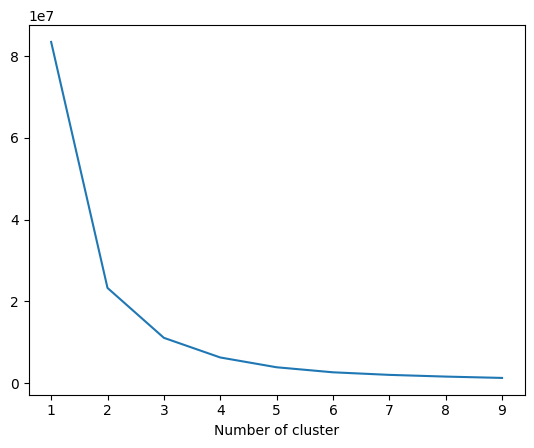

In [84]:
customer_recency = customer[['Recency']]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(customer_recency)
    customer_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [85]:
kmeans = KMeans(n_clusters=4)
customer['Recency_Cluster'] = kmeans.fit_predict(customer[['Recency']])
customer.head()

,Customer_ID,Recency,Recency_Cluster
0,1000,156,2
1,1002,45,0
2,1003,125,2
3,1004,120,2
4,1005,91,2


In [86]:
customer.groupby('Recency_Cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Cluster,,,,,,,,
0,3206.0,39.680911,23.887494,0.0,19.0,39.0,60.0,82.0
1,2407.0,217.382634,27.448922,172.0,193.0,216.0,242.0,266.0
2,2882.0,124.832408,25.249618,83.0,103.0,124.0,146.0,171.0
3,971.0,315.391349,28.068386,267.0,292.0,316.0,339.0,365.0


**Ordering Cluster**

In [87]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customer = order_cluster('Recency_Cluster', 'Recency',customer,False)

In [88]:
customer.head()

,Customer_ID,Recency,Recency_Cluster
0,1000,156,2
1,1002,45,3
2,1003,125,2
3,1004,120,2
4,1005,91,2


In [89]:
customer.groupby('Recency_Cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Cluster,,,,,,,,
0,971.0,315.391349,28.068386,267.0,292.0,316.0,339.0,365.0
1,2407.0,217.382634,27.448922,172.0,193.0,216.0,242.0,266.0
2,2882.0,124.832408,25.249618,83.0,103.0,124.0,146.0,171.0
3,3206.0,39.680911,23.887494,0.0,19.0,39.0,60.0,82.0


**Frequency**

In [91]:
customer_frequency = df_clv.groupby('Customer_ID').Purchase_Date.count().reset_index()
customer_frequency.columns = ['Customer_ID','Frequency']
customer_frequency.head()

,Customer_ID,Frequency
0,1000,1
1,1002,2
2,1003,1
3,1004,1
4,1005,2


In [92]:
customer = pd.merge(customer, customer_frequency, on='Customer_ID')
customer.head()

,Customer_ID,Recency,Recency_Cluster,Frequency
0,1000,156,2,1
1,1002,45,3,2
2,1003,125,2,1
3,1004,120,2,1
4,1005,91,2,2


**Frequency Clusters**

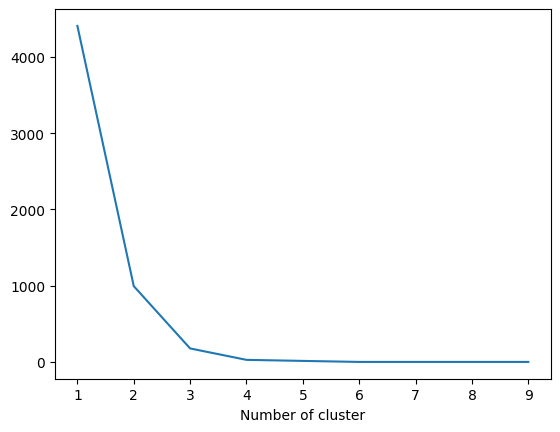

In [98]:
customer_recency = customer[['Frequency']]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(customer_recency)
    customer_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [99]:
kmeans=KMeans(n_clusters=4)
customer['FrequencyCluster']=kmeans.fit_predict(customer[['Frequency']])

customer = order_cluster('FrequencyCluster', 'Frequency', customer, True )
customer.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,6366.0,1.00000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2392.0,2.00000,0.000000,2.0,2.0,2.0,2.0,2.0
2,573.0,3.00000,0.000000,3.0,3.0,3.0,3.0,3.0
3,135.0,4.17037,0.449556,4.0,4.0,4.0,4.0,6.0


In [100]:
customer.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster
0,1000,156,2,1,0
1,1002,45,3,2,1
2,1003,125,2,1,0
3,1004,120,2,1,0
4,1005,91,2,2,1


**Revenue**

In [102]:
df_clv['Revenue'] = df_clv['Unit_Price'] * df_clv['Quantity']
customer_revenue = df_clv.groupby('Customer_ID').Revenue.sum().reset_index()

In [53]:
customer_revenue.head()

,CustomerID,Revenue
0,1000,741.09
1,1002,5020.60
2,1003,41.50
3,1004,83.00
4,1005,11779.11


In [103]:
#merge it with our main dataframe
customer = pd.merge(customer, customer_revenue, on='Customer_ID')
customer.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue
0,1000,156,2,1,0,741.09
1,1002,45,3,2,1,5020.60
2,1003,125,2,1,0,41.50
3,1004,120,2,1,0,83.00
4,1005,91,2,2,1,11779.11


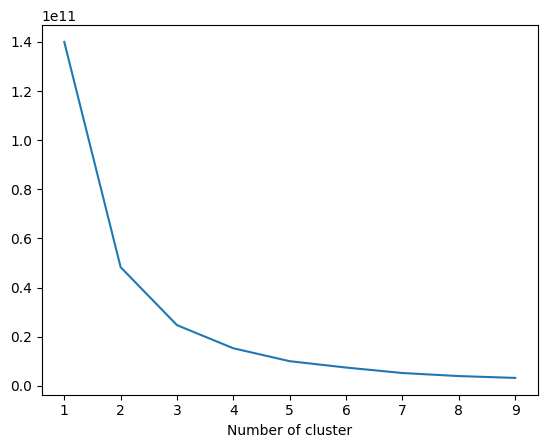

In [104]:
customer_recency = customer[['Revenue']]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(customer_recency)
    customer_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [105]:
kmeans = KMeans(n_clusters=4)
customer['RevenueCluster'] = kmeans.fit_predict(customer[['Revenue']])
customer = order_cluster('RevenueCluster', 'Revenue',customer,True)
customer.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3737.0,1222.519944,817.188730,20.75,463.9600,1204.22,1946.140,2679.74
1,3010.0,4149.207870,939.910205,2687.23,3311.1750,4045.92,4747.140,6032.39
2,2069.0,7933.913577,1333.742014,6035.08,6838.0800,7753.79,8923.910,10982.79
3,650.0,14087.193323,3160.292350,11009.74,11803.5375,13104.97,15201.785,29937.93


In [107]:
customer.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,1000,156,2,1,0,741.09,0
1,1002,45,3,2,1,5020.60,1
2,1003,125,2,1,0,41.50,0
3,1004,120,2,1,0,83.00,0
4,1005,91,2,2,1,11779.11,3


Overall Score Based on Rfm Clustering

In [112]:
customer['OverallScore'] = customer['Recency_Cluster'] + customer['FrequencyCluster'] + customer['RevenueCluster']
customer.head()
customer.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,316.560074,1.000000,968.852569
1,238.396989,1.020602,1743.471474
2,180.543764,1.072210,2669.517079
3,110.110555,1.133067,3246.541486
4,94.187415,1.431664,5010.281874
5,76.665392,1.802103,6693.376157
6,64.365922,2.213687,8912.635782
7,53.464789,2.645070,11650.069662
8,43.039548,3.288136,14047.738644


In [113]:
customer['Segment'] = 'Low-Value'
customer.loc[customer['OverallScore']>2,'Segment'] = 'Mid-Value'
customer.loc[customer['OverallScore']>4,'Segment'] = 'High-Value'

In [114]:
customer.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,1000,156,2,1,0,741.09,0,2,Low-Value
1,1002,45,3,2,1,5020.60,1,5,High-Value
2,1003,125,2,1,0,41.50,0,2,Low-Value
3,1004,120,2,1,0,83.00,0,2,Low-Value
4,1005,91,2,2,1,11779.11,3,6,High-Value


**Customer LifeTime Value**

In [115]:
df_clv['Purchase_Date'].describe()

,Purchase_Date
count,13432
mean,2024-04-18 04:57:29.910661120
min,2023-09-24 00:00:00
25%,2024-02-04 00:00:00
50%,2024-04-24 00:00:00
75%,2024-07-08 00:00:00
max,2024-09-23 00:00:00


In [129]:
customer_3m = df_clv[(df_clv.Purchase_Date < datetime(2024,4,24)) & (df_clv.Purchase_Date >= datetime(2024,1,24))].reset_index(drop=True)
customer_6m = df_clv[(df_clv.Purchase_Date >= datetime(2024,4,24)) & (df_clv.Purchase_Date < datetime(2024,10,1))].reset_index(drop=True)

In [130]:

customer_6m['Revenue'] = customer_6m['Unit_Price'] * customer_6m['Quantity']
customer_6m = customer_6m.groupby('Customer_ID')['Revenue'].sum().reset_index()
customer_6m.columns = ['Customer_ID','m6_Revenue']

In [131]:
customer_6m.head()

,Customer_ID,m6_Revenue
0,1002,3164.76
1,1003,41.50
2,1004,83.00
3,1005,4175.64
4,1006,2470.30


In [132]:
plot_data = [go.Histogram(x=customer_6m['m6_Revenue'])]
plot_layout = go.Layout( title='6m Revenue')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [135]:
customer_merge = pd.merge(customer,customer_6m, on='Customer_ID', how='left')

In [134]:
merge = customer_merge.fillna(0)
tx_graph = customer_merge.query("m6_Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
        line= dict(width=1),color= 'blue',opacity= 0.8)),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',name='Mid',
        marker= dict(size= 9,line= dict(width=1),color= 'green',opacity= 0.5)),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',name='High',marker= dict(size= 11,line= dict(width=1),color= 'red',opacity= 0.9)),]
plot_layout = go.Layout(yaxis= {'title': "6m LTV"},xaxis= {'title': "RFM Score"},title='LTV')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [136]:
customer_merge = customer_merge[customer_merge['m6_Revenue']<customer_merge['m6_Revenue'].quantile(0.99)]

In [137]:
customer_merge.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
1,1002,45,3,2,1,5020.60,1,5,High-Value,3164.76
2,1003,125,2,1,0,41.50,0,2,Low-Value,41.50
3,1004,120,2,1,0,83.00,0,2,Low-Value,83.00
4,1005,91,2,2,1,11779.11,3,6,High-Value,4175.64
5,1006,90,2,2,1,6645.94,2,5,High-Value,2470.30


In [138]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
customer_merge['LTVCluster'] = kmeans.fit_predict(customer_merge[['m6_Revenue']])
customer_merge.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
1,1002,45,3,2,1,5020.60,1,5,High-Value,3164.76,1
2,1003,125,2,1,0,41.50,0,2,Low-Value,41.50,1
3,1004,120,2,1,0,83.00,0,2,Low-Value,83.00,1
4,1005,91,2,2,1,11779.11,3,6,High-Value,4175.64,0
5,1006,90,2,2,1,6645.94,2,5,High-Value,2470.30,1


In [139]:
customer_merge = order_cluster('LTVCluster', 'm6_Revenue',customer_merge,True)
customer_cluster = customer_merge.copy()
customer_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3031.0,1646.058383,1051.973058,20.75,741.090,1582.38,2528.2600,3447.26
1,1714.0,5242.858086,1104.055639,3524.85,4175.640,5068.98,6227.6575,7315.72
2,776.0,9430.363686,1679.794636,7351.09,7976.035,9117.44,10257.1200,14350.48


In [140]:
#convert categorical columns to numerical
customer_class = pd.get_dummies(customer_cluster) #There is only one categorical variable segment
customer_class.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,1002,45,3,2,1,5020.60,1,5,3164.76,0,True,False,False
1,1003,125,2,1,0,41.50,0,2,41.50,0,False,True,False
2,1004,120,2,1,0,83.00,0,2,83.00,0,False,True,False
3,1005,91,2,2,1,11779.11,3,6,4175.64,1,True,False,False
4,1006,90,2,2,1,6645.94,2,5,2470.30,0,True,False,False


In [141]:
#calculate and show correlations
corr_matrix = customer_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

,LTVCluster
LTVCluster,1.000000
m6_Revenue,0.919337
RevenueCluster,0.712039
Revenue,0.710866
OverallScore,0.564425
Segment_High-Value,0.481663
FrequencyCluster,0.240226
Frequency,0.239499
Customer_ID,0.146276
Recency_Cluster,0.092878


In [142]:
X = customer_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = customer_class['LTVCluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [145]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, n_jobs=-1, learning_rate=0.1).fit(X_train, y_train)
print("Accuracy: %.2f%%" % (ltv_xgb_model.score(X_test, y_test) * 100.0))
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy: 82.67%
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       151
           1       0.72      0.79      0.75        87
           2       0.65      0.82      0.73        39

    accuracy                           0.83       277
   macro avg       0.78      0.82      0.80       277
weighted avg       0.85      0.83      0.83       277

